# Clustering analysis of EhV data using SCIP and IDEAS features

In [1]:
# %load common_.py
from common import *

In [2]:
import fcsparser

# Data import

In [11]:
df_scip = pq.read_table("/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo/datasets/weizmann/EhV/v2/results/scip/202111181000/features.parquet").to_pandas()
df_scip["meta_object_number"] = df_scip.index.map(lambda a: a.split("_")[1]).astype(int)
df_scip["meta_group"] = df_scip["meta_group"].astype(int)
df_scip["meta_replicate"] = df_scip["meta_replicate"].astype(int)
df_scip = df_scip[numpy.load("/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo/datasets/weizmann/EhV/v2/results/scip/202111161230/columns.npy", allow_pickle=True)]
df_scip.shape

(142451, 407)

In [12]:
# filter out cells for which no mask was found in the bbox channel
df_scip = df_scip[~df_scip["meta_bbox_minr"].isna()]
df_scip.shape

(126014, 407)

In [13]:
# ideas features
tmp = []
for p in Path("/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo/datasets/weizmann/EhV/v2/results/ideas/202111031041/").glob('*.fcs'):
    meta, data = fcsparser.parse(p)
    groups = re.search("^(?P<type>\w+)_T(?P<group>[0-9]+)_R(?P<replicate>[0-9]+)", p.name).groupdict()
    data["type"] = groups["type"]
    data["group"] = int(groups["group"])
    data["replicate"] = int(groups["replicate"])
    tmp.append(data)
df_ideas = pandas.concat(tmp, axis=0)

r = r"(?i).*(uncompensated|bkgd|saturation|\().*" 
todrop = list(filter(lambda x: re.match(r, x), df_ideas.columns))
df_ideas = df_ideas.drop(columns=todrop)

ideas_meta_cols = ["Object Number", "type", "group", "replicate"]
df_ideas = df_ideas.rename(columns=lambda col: f"meta_{col.lower()}" if col in ideas_meta_cols else f"feat_{col.lower()}")

df_ideas["meta_object_number"] = df_ideas["meta_object number"].astype(int)
df_ideas = df_ideas.drop(columns="meta_object number")

df_ideas.shape

(144421, 159)

In [14]:
df_scip = df_scip.set_index(["meta_object_number", "meta_replicate", "meta_group", "meta_type"])
df_ideas = df_ideas.set_index(["meta_object_number", "meta_replicate", "meta_group", "meta_type"])

In [15]:
df = df_scip.rename(columns=lambda a: "scip_"+a).join(
    df_ideas.rename(columns=lambda a: "ideas_"+a), 
    on=["meta_object_number", "meta_replicate", "meta_group", "meta_type"], 
    how="inner", lsuffix="ideas", rsuffix="scip"
)
df.shape

(125399, 558)

In [16]:
def rename(c):
    if c.startswith("scip_meta"):
        return "meta_" + c[10:]
    return c
df = df.rename(columns=rename)

In [17]:
df.head()

,,,,meta_bbox_minr,meta_bbox_minc,meta_bbox_maxr,meta_bbox_maxc,meta_regions_0,meta_regions_1,meta_regions_2,meta_regions_3,meta_regions_4,meta_regions_5,...,ideas_feat_similarity_m01_dapi_tmr,ideas_feat_bright detail similarity r3_mc_tmr_dapi,ideas_feat_bright detail similarity r3_mc_tmr_cy5,ideas_feat_intensity_m06_ch06,ideas_feat_max pixel_m06_ch06,ideas_feat_mean pixel_m06_ch06,ideas_feat_median pixel_m06_ch06,ideas_feat_aspect ratio_m06,ideas_feat_angle intensity_m06_ch06,ideas_feat_aspect ratio intensity_m06_ch06
meta_object_number,meta_replicate,meta_group,meta_type,,,,,,,,,,,,,,,,,,,,,
21519,1,0,Ctrl,16.0,9.0,28.0,19.0,1.0,0.0,0.0,1.0,1.0,1.0,...,-0.897054,1.266814,1.131434,5283.871094,213.290329,41.605282,27.290323,0.604436,0.104471,0.461202
2840,1,0,Ctrl,19.0,12.0,38.0,29.0,1.0,2.0,0.0,1.0,1.0,2.0,...,0.264883,1.315778,1.856017,13387.307617,239.667679,44.182533,25.667683,0.652591,0.507735,0.401893
5782,1,0,Ctrl,10.0,9.0,21.0,20.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.222503,1.242110,2.354448,2446.430664,81.023148,23.299339,18.023148,0.530188,0.042922,0.439835
2335,1,0,Ctrl,12.0,10.0,25.0,21.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.003013,1.236928,1.173388,5357.189453,156.526520,33.906261,20.026516,0.553332,0.103705,0.423454
17926,1,0,Ctrl,17.0,11.0,29.0,26.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.443109,0.919483,1.158279,6226.058594,216.970581,30.822073,21.470589,0.725518,0.191983,0.475378


# Predicting IDEAS gated single-cell, focused events from SCIP features

In [18]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

In [19]:
X = df.filter(regex="scip_feat")
y = df["meta_label"] != "unknown"

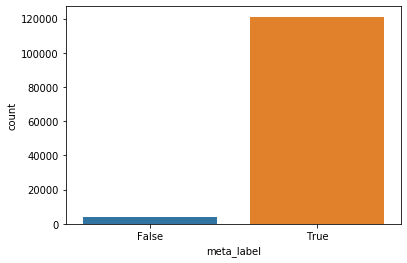

In [20]:
seaborn.countplot(x=y)

In [21]:
scale_pos_weight = (len(y)-sum(y))/sum(y)
scale_pos_weight

0.03548248583838417

In [22]:
%%time
scoring = ('balanced_accuracy', 'f1', 'precision', 'recall', 'roc_auc')
cv_results = cross_validate(
    estimator=XGBClassifier(use_label_encoder=False, scale_pos_weight=scale_pos_weight),
    X=X, y=y.values.astype(int), cv=5,
    scoring=scoring,
    return_train_score=True,
    return_estimator=True,
    n_jobs=-1
)

CPU times: user 325 ms, sys: 1.72 s, total: 2.04 s
Wall time: 3min 33s


In [23]:
cv_df = pandas.DataFrame(
    data = {
        **{"phase": ["train"] * 5 + ["test"] * 5},
        **{k: numpy.concatenate([cv_results[f"train_{k}"], cv_results[f"test_{k}"]]) for k in scoring}
    }
).melt(id_vars=["phase"])

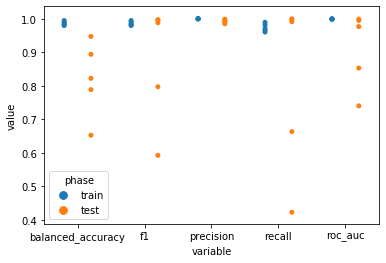

In [24]:
seaborn.stripplot(data=cv_df, x="variable", y="value", hue="phase", dodge=True, jitter=0)

## SHAP explanation

In [184]:
import shap
shap.initjs()

In [178]:
model = XGBClassifier(use_label_encoder=False, scale_pos_weight=scale_pos_weight).fit(X, y.values.astype(int))

[13:37:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [183]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


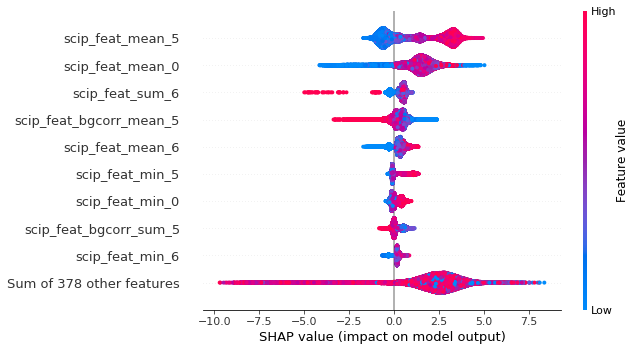

In [185]:
shap.plots.beeswarm(shap_values)

# Continue with IDEAS gated events only

In [25]:
df = df[df["meta_label"] != "unknown"]
df.shape

(121102, 558)

# QC plots of control and infected samples

In [26]:
import flowutils

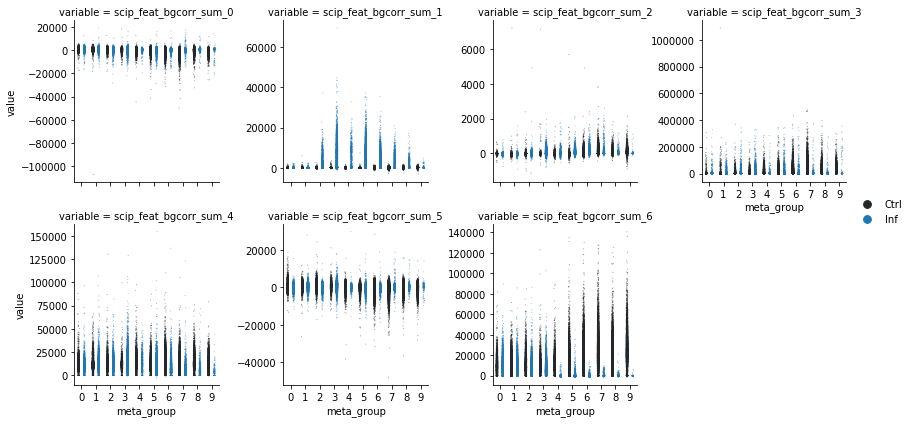

[10:44:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:44:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:44:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:44:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [27]:
melted_df = pandas.melt(df.reset_index(), id_vars=["meta_type", "meta_group", "meta_replicate"], value_vars=df.filter(regex="scip_feat_bgcorr_sum_[0-9]").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", col_wrap=4, sharey=False)
grid.map_dataframe(seaborn.stripplot, x="meta_group", y="value", hue="meta_type", dodge=True, size=1, alpha=0.5)
grid.add_legend()

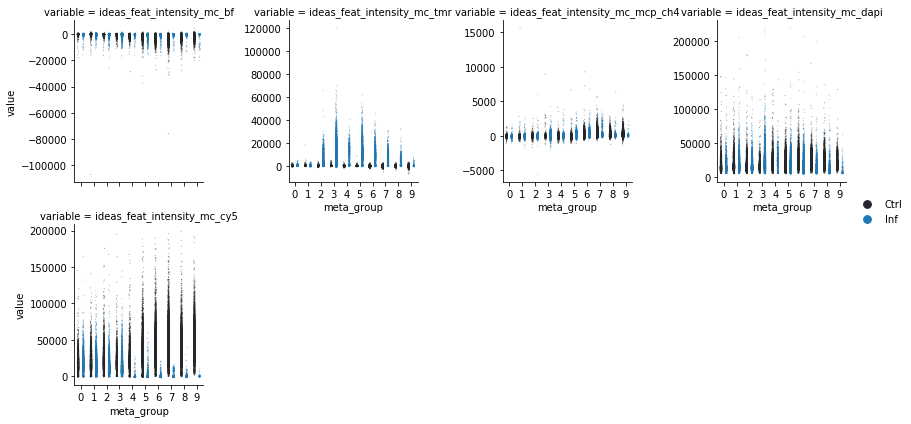

In [28]:
melted_df = pandas.melt(df.reset_index(), id_vars=["meta_type", "meta_group", "meta_replicate"], value_vars=df.filter(regex="ideas_feat_intensity_mc").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", col_wrap=4, sharey=False)
grid.map_dataframe(seaborn.stripplot, x="meta_group", y="value", hue="meta_type", dodge=True, size=1, alpha=0.5)
grid.add_legend()

In [29]:
for k, gdf in df.groupby("meta_group"):
    gdf = gdf[["scip_feat_bgcorr_sum_1", "scip_feat_bgcorr_sum_4", "scip_feat_bgcorr_sum_6"]]
    transf = flowutils.transforms.logicle(gdf.values, w=1, channel_indices=None)
    df.loc[(slice(None), slice(None), k, slice(None)), ["scip_feat_bgcorr_sum_logicle_1", "scip_feat_bgcorr_sum_logicle_4", "scip_feat_bgcorr_sum_logicle_6"]] = transf

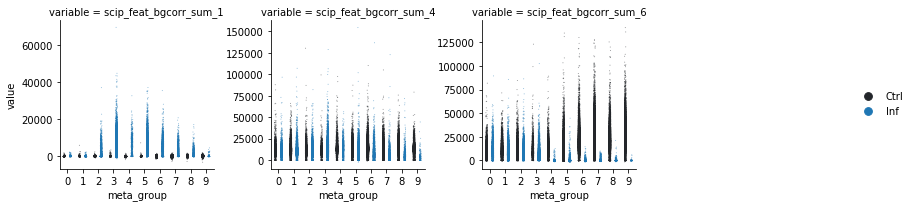

In [30]:
melted_df = pandas.melt(df.reset_index(), id_vars=["meta_type", "meta_group", "meta_replicate"], value_vars=df.filter(regex="scip_feat_bgcorr_sum_[1,4,6]").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", col_wrap=4, sharey=False)
grid.map_dataframe(seaborn.stripplot, x="meta_group", y="value", hue="meta_type", dodge=True, size=1, alpha=0.5)
grid.add_legend()

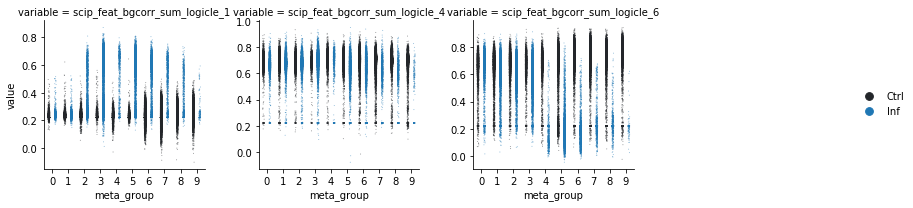

In [31]:
melted_df = pandas.melt(df.reset_index(), id_vars=["meta_type", "meta_group", "meta_replicate"], value_vars=df.filter(regex="scip_feat_bgcorr_sum_logicle_[0-9]").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", col_wrap=4, sharey=False)
grid.map_dataframe(seaborn.stripplot, x="meta_group", y="value", hue="meta_type", dodge=True, size=1, alpha=0.5)
grid.add_legend()

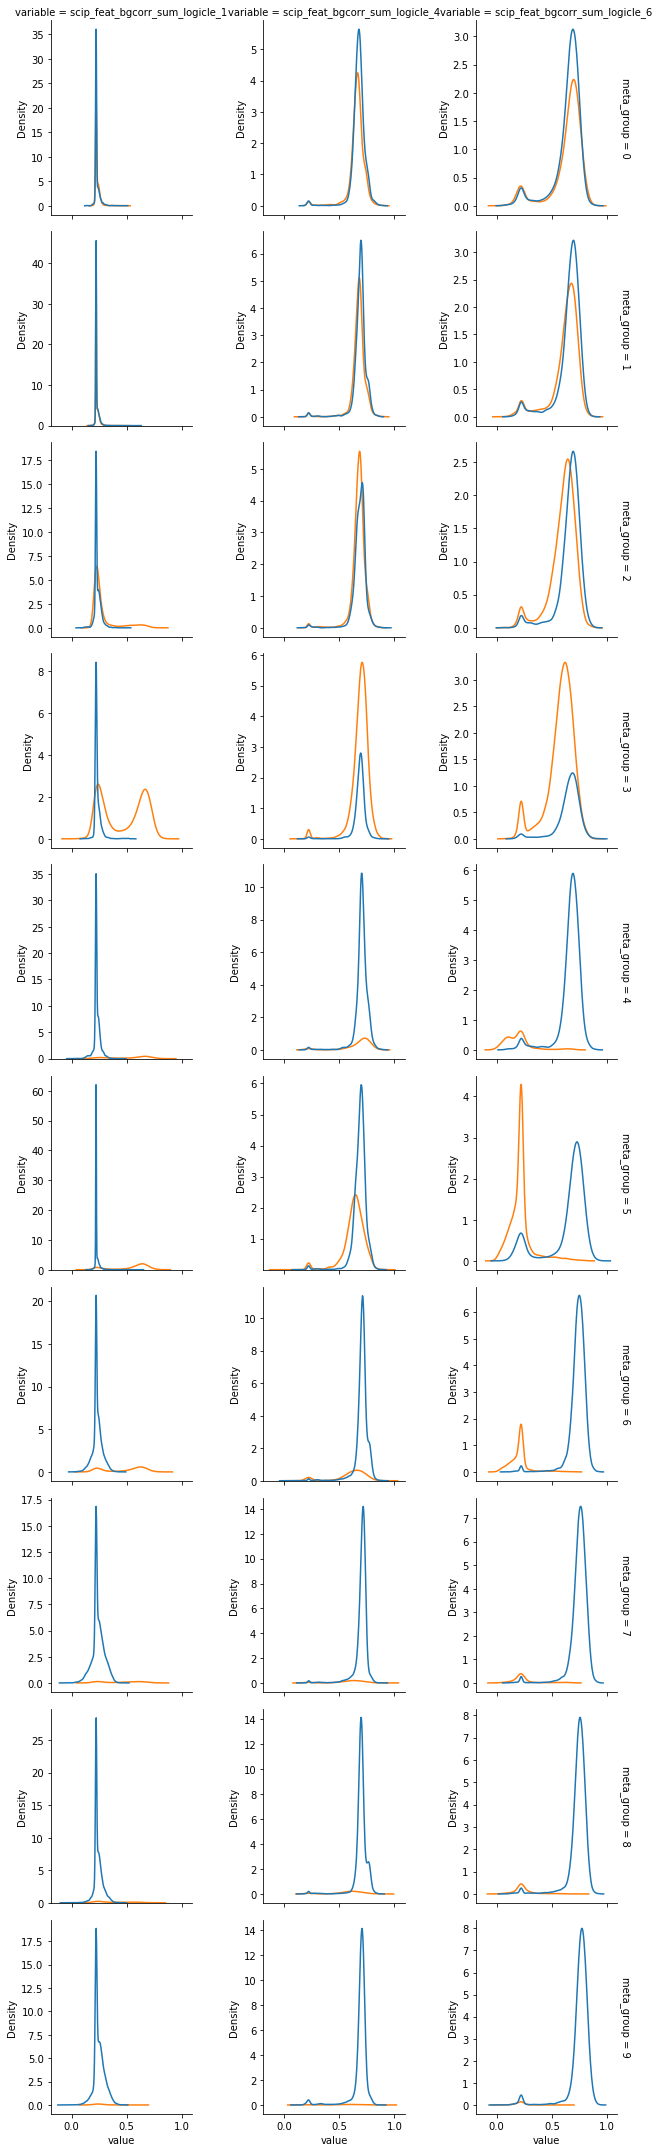

In [32]:
melted_df = pandas.melt(df.reset_index(), id_vars=["meta_type", "meta_group", "meta_replicate"], value_vars=df.filter(regex="scip_feat_bgcorr_sum_logicle_[0-9]").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", row="meta_group", sharey=False, margin_titles=True)
grid.map_dataframe(seaborn.kdeplot, x="value", hue="meta_type")
grid.add_legend()

# Clustering

In [191]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize, scale, minmax_scale, LabelEncoder
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

In [300]:
y = LabelEncoder().fit_transform(df["meta_label"])

In [301]:
idx, _ = train_test_split(numpy.arange(len(df)), test_size=0.7, stratify=y)

In [302]:
X = df.filter(regex="scip_feat").iloc[idx].values
y = y[idx]
cols = df.filter(regex="scip_feat").columns.values

In [303]:
v = VarianceThreshold().fit(X)
X = v.transform(X)

In [304]:
cols = cols[v.get_support()]

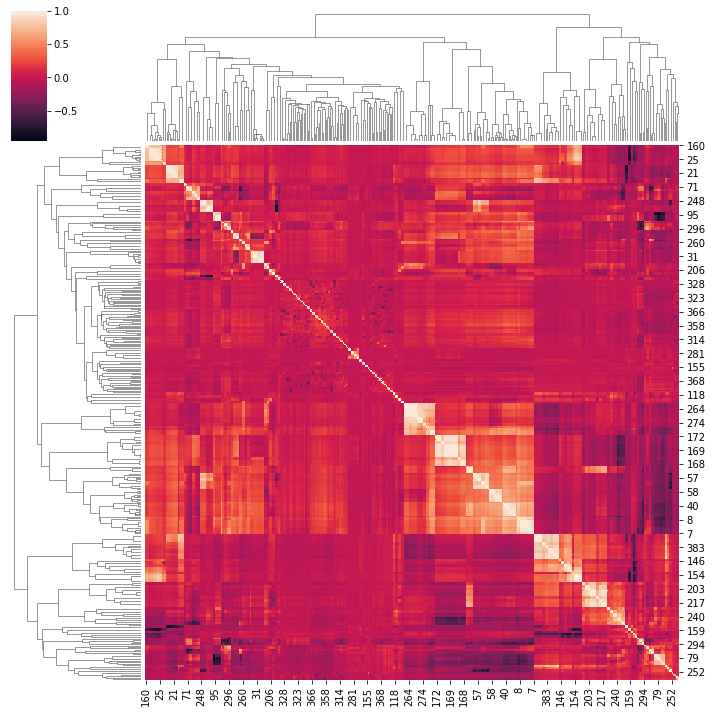

In [305]:
seaborn.clustermap(numpy.corrcoef(X, rowvar=False))

In [306]:
class Correlation():
    def __init__(self, thresh):
        self.thresh = thresh
    
    def fit(self, X):
        correlation = numpy.corrcoef(X, rowvar=False)
        var = X.var(axis=1)
        drop = set()
        for i in range(correlation.shape[0]):
            for j in range(i):
                if abs(correlation[i, j]) > self.thresh:
                    if var[i] >= var[j]:
                        c = i
                    else:
                        c = j
                    drop.add(c)
                    
        self.drop = list(drop)
        return self
        
    def transform(self, X, axis=1):
        return numpy.delete(X, self.drop, axis=axis)

In [307]:
corr = Correlation(0.9).fit(X)
X = corr.transform(X)
X.shape

(36330, 180)

In [308]:
cols = corr.transform(cols, axis=0)
len(cols)

180

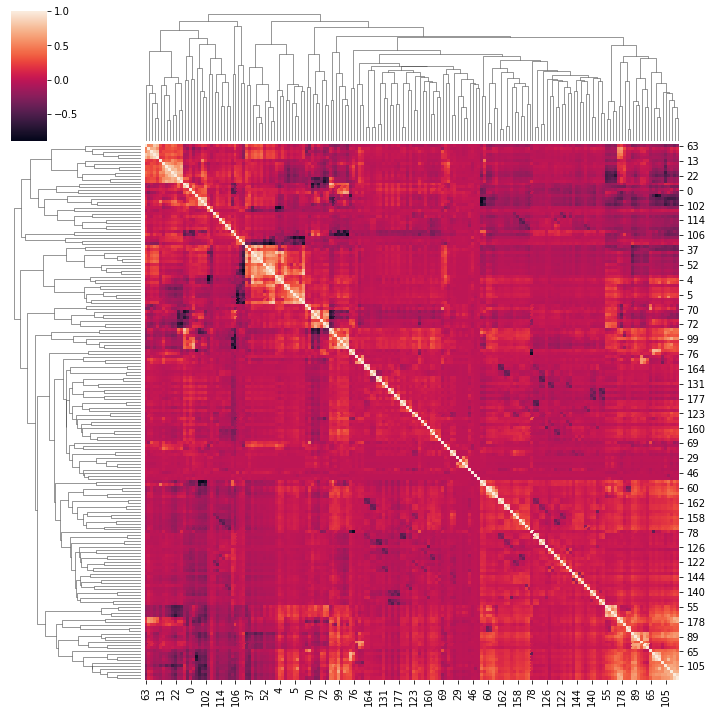

In [309]:
seaborn.clustermap(numpy.corrcoef(X, rowvar=False))

## Hierarchical clustering

In [310]:
%%time
agg = AgglomerativeClustering(
    n_clusters = 4,
    linkage = "ward"
).fit(scale(X))

CPU times: user 2min 39s, sys: 3.07 s, total: 2min 42s
Wall time: 2min 42s


In [311]:
normalized_mutual_info_score(agg.labels_, y)

0.2739861757826867

In [312]:
adjusted_rand_score(agg.labels_, y)

0.20588269553738828

In [313]:
pca = PCA().fit_transform(scale(X))

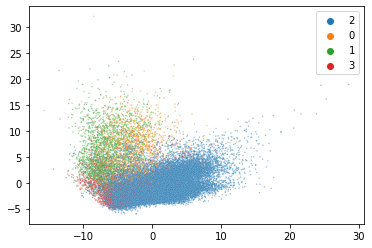

In [314]:
seaborn.scatterplot(x=pca[:, 0], y=pca[:, 1], edgecolors="none", hue=y.astype(str), s=2, alpha=0.5)

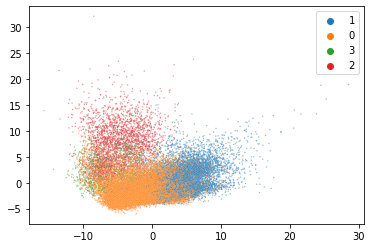

In [315]:
seaborn.scatterplot(x=pca[:, 0], y=pca[:, 1], edgecolors="none", hue=agg.labels_.astype(str), s=2, alpha=0.5)

In [316]:
df["meta_agg_clus"] = -1
df.iloc[idx, df.columns.get_loc("meta_agg_clus")] = agg.labels_

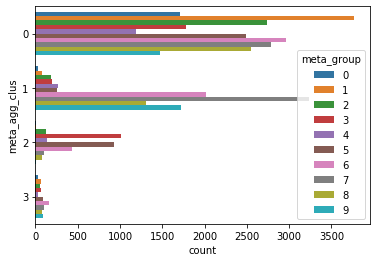

In [317]:
seaborn.countplot(data=df.iloc[idx].reset_index(), y="meta_agg_clus", hue="meta_group")

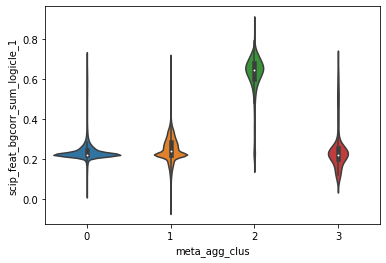

In [318]:
seaborn.violinplot(data=df.iloc[idx].reset_index(), y="scip_feat_bgcorr_sum_logicle_1", x="meta_agg_clus")

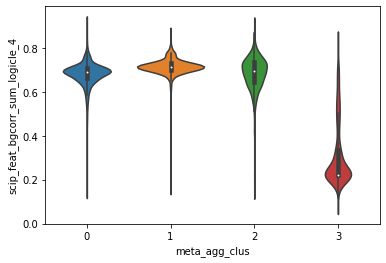

In [319]:
seaborn.violinplot(data=df.iloc[idx].reset_index(), y="scip_feat_bgcorr_sum_logicle_4", x="meta_agg_clus")

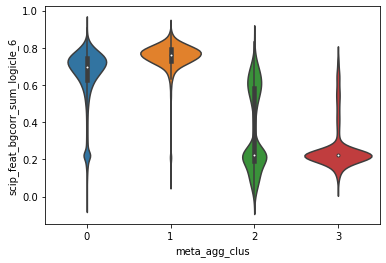

In [320]:
seaborn.violinplot(data=df.iloc[idx].reset_index(), y="scip_feat_bgcorr_sum_logicle_6", x="meta_agg_clus")

In [321]:
import shap
shap.initjs()

In [322]:
X = df.filter(regex="scip_feat").iloc[idx]
y = df["meta_agg_clus"].iloc[idx]
model = XGBClassifier(use_label_encoder=False).fit(X.values, y.values.astype(int))

[12:44:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [323]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [324]:
shap.plots.force(shap_values[0, :, 3])

In [325]:
shap.plots.force(shap_values[0, :, 2])

In [326]:
shap.plots.force(shap_values[0, :, 1])

In [327]:
shap.plots.force(shap_values[0, :, 0])

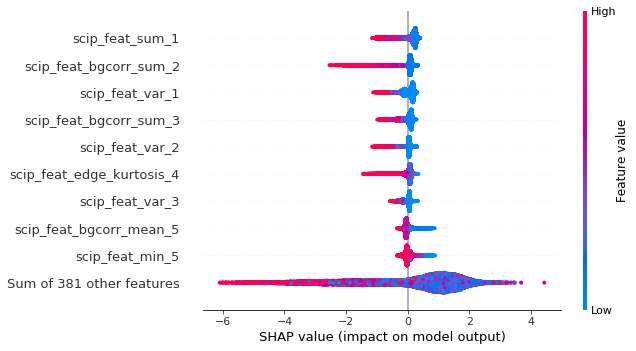

In [328]:
shap.plots.beeswarm(shap_values[..., 0])

## FlowSOM clustering

In [97]:
from rpy2.robjects.packages import importr

ValueError: r_home is None. Try python -m rpy2.situation